In [36]:
import os, sys
from pathlib import Path
import torch
import tifffile as tiff

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

ncomps = 50
model_comps = 500
dr_method = 'PCA'

exp_name="far_bias"

test_path = train_path = macaw_path/exp_name/f'test_hc_data_PCA_{model_comps}.pkl'
model_base_path = macaw_path/'models'/exp_name/f'{dr_method}_{model_comps}'/f'{ncomps}'

In [37]:
import pickle

with open(test_path, 'rb') as f:
    test = pickle.load(f)
    
disease = test['disease']
bias = test['bias']
test_imgs = test['imgs']

encoded_data = test['encoded_data']
pca = test['pca']

img_names = test['img_names']

In [38]:
with open(model_base_path/'hyperparameters.pkl', 'rb') as f:
    hp = pickle.load(f)
    
ncomps= hp['ncomps']
nevecs= hp['nevecs']
nbasecomps= hp['nbasecomps']
ncauses= hp['ncauses']
crop_size= hp['crop_size']

In [39]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

def recons(age,bmi,latents, latent_offset=0):
    
    # bmi = scaler_b.inverse_transform(bmi)
    # print(age)
    latent_enc = np.zeros((latents.shape[0],ncomps))
    latent_enc[:,latent_offset:latent_offset+latents.shape[1]] = latents    
    # latent_enc = scaler_i.inverse_transform(latent_enc)
    imgs = pca.inverse_transform(latent_enc)
    return age,bmi,imgs

In [40]:
sample_imgs = test_imgs[:5,:]
t = pca.transform(sample_imgs)
X_recon = pca.inverse_transform(t)

In [41]:
def make_img(x):
    img = (255*x/np.max(x)).reshape(crop_size,crop_size)
    return np.clip(img,0, 255).astype('uint8')

In [42]:
import glob
from PIL import Image

def make_gif(frames, save_name):    
    frames = [Image.fromarray(f) for f in frames]
    frame_one = frames[0]
    return frame_one.save(save_name, format="GIF", append_images=frames, save_all=True, duration=100, loop=0)

In [43]:
print(img_names[247], img_names[248])

00247_-0.253_S_-1.014_D_2.431_B.tiff 00248_0.455_S_0.342_D.tiff


In [44]:
from torchvision.transforms import CenterCrop
from utils.customTransforms import ToFloatUKBB
from monai.transforms import Compose, ToTensor
transforms = Compose([ToTensor(),CenterCrop(crop_size),ToFloatUKBB()])

In [45]:
import SimpleITK as sitk
import numpy as np
import torch

save_name = f'data/{exp_name}/cntr/'
cf_vals = {1:0}
image_shape = (180, 180)  # Assuming each image is 180x180

# rands = np.random.randint(0, encoded_data.shape[0], nsamples)
# d_obs = test_imgs[rands, :]
# encoded_obs = encoded_data[rands, :]
# 
# names = img_names[rands]
# dis_obs = disease[rands]
# bias_obs = bias[rands]
residuals = test_imgs - pca.inverse_transform(encoded_data)

cf = np.zeros((248, ncomps))
for ev in range(0, ncomps - nbasecomps, nevecs - nbasecomps):
    ed = encoded_data[:248, ev:ev + nevecs]
    X_obs = np.hstack([disease[:248, np.newaxis], bias[:248, np.newaxis], ed])
    try:
        macaw = torch.load(model_base_path / f'{ev}.pt')
        cc = macaw.counterfactual(X_obs, cf_vals)
    except Exception as e:
        print(e, "Using original")
        cc[:, ncauses:] = X_obs[:, ncauses:].copy()

    cf[:, ev:ev + nevecs] = cc[:, ncauses:]

re_cf = recons(cc[:, 0], cc[:, 1], cf)
re_cf_resd = re_cf[2] + residuals[:248]

# Convert numpy arrays to SimpleITK images
def numpy_to_sitk(img):
    return sitk.GetImageFromArray(img.astype(np.float32))

def sitk_to_numpy(img):
    return sitk.GetArrayFromImage(img)

# Perform histogram matching
matched_images = []
for i in range(248):
    # Reshape the arrays to 2D images
    source_img_2d = re_cf_resd[i].reshape(image_shape).astype(np.float32)
    reference_img_2d = test_imgs[i].reshape(image_shape).astype(np.float32)
    
    source_img = numpy_to_sitk(source_img_2d)
    reference_img = numpy_to_sitk(reference_img_2d)
    
    matcher = sitk.HistogramMatchingImageFilter()
    matcher.SetNumberOfHistogramLevels(500)
    matcher.SetNumberOfMatchPoints(50)
    matcher.SetThresholdAtMeanIntensity(False)
    matched_img = matcher.Execute(source_img, reference_img)
    
    # Convert the matched image back to a numpy array and reshape to original shape
    matched_img_array = sitk_to_numpy(matched_img).reshape(-1)
    matched_images.append(matched_img_array)

# Convert the matched images back to a numpy array
re_cf_resd = np.array(matched_images)

# Ensuring values are still in the range [0, 1] after histogram matching
# re_cf_resd = np.clip(re_cf_resd, 0, 1)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
home_dir = './'
working_dir = home_dir + exp_name + '/'

# def make_img(x):
#     img = (255*x/np.max(x)).reshape(crop_size,crop_size)
#     return np.clip(img,0, 255).astype('uint8')
# 
# for img in re_cf_resd:
#     img = make_img(img)

In [47]:
re_cf_resd.shape

(248, 32400)

In [48]:
re_cf_resd[0].min()

0.0

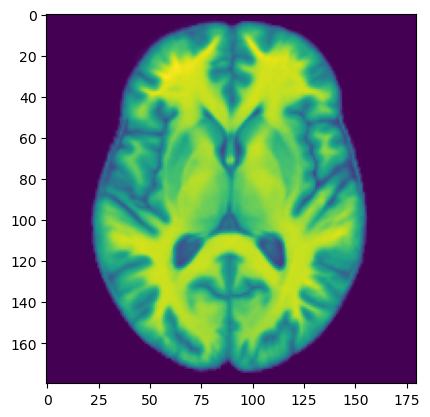

In [49]:
plt.imshow(re_cf_resd[0].reshape(180,180))

In [50]:
nob_gt=[]

transforms_t = Compose([ToFloatUKBB(), ToTensor(), CenterCrop(crop_size)])

for i in range(248):
    img = tiff.imread('no_bias/test/'+img_names[i])
    # img = img / np.max(img)
    nob_gt.append(transforms_t(img).numpy())
    
# nob_gt = np.concatenate(nob_gt, axis=0)
# nob_gt = nob_gt.reshape(nob_gt.shape[0], -1)
nob_gt=np.array(nob_gt)
nob_gt_t = torch.tensor(nob_gt, dtype=torch.float32)

In [51]:
from monai.transforms import EnsureChannelFirst
import torchvision
from monai.data import DataLoader, ImageDataset
import pandas as pd
df_test = pd.read_csv(os.path.join(home_dir, "splits/test.csv"))

test_fpaths = [os.path.join(working_dir, "test", filename) for filename in df_test['filename']]
test_class_label = df_test['bias_label']

# Define transforms for image
transforms = Compose([torchvision.transforms.CenterCrop(180), EnsureChannelFirst(), ToFloatUKBB(), ToTensor()])

# Define image dataset
test_ds = ImageDataset(image_files=test_fpaths, labels=test_class_label, transform=transforms, image_only=True, reader="PILReader")

# create a validation data loader
test_loader = DataLoader(test_ds, batch_size=32, num_workers=4, pin_memory=torch.cuda.is_available())

In [52]:
from tqdm import tqdm
import pandas as pd
from utils.utils import *
from SFCN import SFCNModel

model = SFCNModel().to(device)
model.load_state_dict(torch.load(working_dir + "best_model_" + exp_name + ".pth"))

model.eval()

re_cf_resd= re_cf_resd.reshape(re_cf_resd.shape[0], 1, crop_size,crop_size)

all_preds = []
with torch.no_grad():
    # saver = CSVSaver(output_dir="./output")
        for idx, test_data in tqdm(enumerate(test_loader), total=len(test_loader)):
            test_images = test_data[0].to(device)

            print(test_data[0][0].max(), test_data[0][0].min())

            # Get model's probability outputs
            outputs = model(test_images)
            # probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(outputs.cpu().numpy())

    # saver.save_batch(torch.tensor(test_outputs).to(device), test_images.meta)

# concat predictions to test dataframe
df_test = df_test.iloc[:248]
df = model_eval(df_test, all_preds)

#create one-hot encoded columns for TP, TN, FP, FN
df['TP'] = df.apply(lambda row: 1 if ((row['bias_label'] == 1) & (row['preds'] ==1)) else 0, axis=1)
df['TN'] = df.apply(lambda row: 1 if ((row['bias_label'] == 0) & (row['preds'] ==0)) else 0, axis=1)
df['FP'] = df.apply(lambda row: 1 if ((row['bias_label'] == 0) & (row['preds'] ==1)) else 0, axis=1)
df['FN'] = df.apply(lambda row: 1 if ((row['bias_label'] == 1) & (row['preds'] ==0)) else 0, axis=1)

df.to_csv(working_dir + 'preds_' + exp_name + '.csv') #save file with predictions

100%|██████████| 16/16 [00:00<00:00, 92.23it/s]


metatensor(1.) metatensor(0.)
metatensor(1.) metatensor(0.)
metatensor(1.) metatensor(0.)
metatensor(1.) metatensor(0.)
metatensor(1.) metatensor(0.)
metatensor(1.) metatensor(0.)
metatensor(1.) metatensor(0.)
metatensor(1.) metatensor(0.)
metatensor(1.) metatensor(0.)
metatensor(1.) metatensor(0.)
metatensor(1.) metatensor(0.)
metatensor(1.) metatensor(0.)
metatensor(1.) metatensor(0.)
metatensor(1.) metatensor(0.)
metatensor(1.) metatensor(0.)
metatensor(1.) metatensor(0.)
Shape of y_pred_raw: (499, 1)


ValueError: Length of values (499) does not match length of index (248)

In [ ]:
# Compute metrics
df_B1 = df.loc[df['ground_truth']==1]
df_B0 = df.loc[df['ground_truth']==0]

#generate file with performance metrics
metrics = compute_metrics(df, save_dir=working_dir, label='Agg')
metrics_B1 = compute_metrics(df_B1, save_dir=working_dir, label='B1')
metrics_B0 = compute_metrics(df_B0, save_dir=working_dir, label='B0')

metrics_df = pd.DataFrame(['Acc', 'Sens', 'Spec', 'FPR', 'AUROC'], columns=['metrics'])
metrics_df = metrics_df.set_index('metrics')

metrics_df['Aggregate'] = metrics
metrics_df['disease_1'] = metrics_B1
metrics_df['disease_0'] = metrics_B0
metrics_df.to_csv(working_dir + 'metrics_' + exp_name + '.csv')

plot_roc_curves(df, df_B1, df_B0, save_dir=working_dir)